In [8]:
# -*- coding: utf-8 -*-
# Normal Python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import numpy as np
from glob import glob
import os

# Plotting packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import box, LineString, Point
import cmocean as cm

# Add the path to the Tatsu's swot library
import sys
sys.path.append('../src/')
import swot_utils
import data_loaders
import download_swaths


# Turn off warnings
import warnings
warnings.filterwarnings("ignore")


# Load a bathymetry dataset for plotting (optional)

In [6]:
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile
    import os

    import requests
    
    # Download bathymetry if you don't have it already..
    if not os.path.exists("../ne_10m_bathymetry_all/"):
        import requests
        r = requests.get(zip_file_url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall("../ne_10m_bathymetry_all/")
    
    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob('../ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (-180, -90, 180, 90)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict


if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

# A notebook to try some plotting

# Load the swath/pass combos you want

Assuming you already have everything downloaded..

In [9]:
# Specify the path to the subsetted data
L3_kuroshio_path = f"../SWOT_L3/Unsmoothed_kuroshio"

# Define domain
# Rough East of Japan domain (Kuroshio-ish)
kuroshio_sw_corner = [140,15]
kuroshio_ne_corner = [170,40]
lat_lims = [kuroshio_sw_corner[1],kuroshio_ne_corner[1]]

# Define mission phase (1-day repeat vs science) and 
# cycles we are interested in
# Use sph_calval_swath for the 1-day repeats
path_to_sph_file="../orbit_data/sph_calval_swath.zip"
# Cycles 474 - 578 are from the 1-day repeat 
cycles = [str(c_num).zfill(3) for c_num in range(474,480)]

pass_IDs_list = download_swaths.find_swaths(kuroshio_sw_corner, kuroshio_ne_corner,
                                           path_to_sph_file=path_to_sph_file)

cycle_data = {}
for cycle in cycles:
    cycle_data[cycle] = data_loaders.load_cycle(L3_kuroshio_path,fields=["time","ssha","ssha_unedited","ssha_noiseless","sigma0"],
                                                cycle=cycle,pass_ids=pass_IDs_list,subset=False,lats=lat_lims
                                               )


Loading SWOT_L3_LR_SSH_Unsmoothed_474_019_20230329T132147_20230329T141138_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_475_004_20230330T002601_20230330T011706_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_476_019_20230331T130302_20230331T135253_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_004_20230401T235753_20230402T004859_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_019_20230402T124418_20230402T133408_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_479_004_20230402T234831_20230403T001052_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_479_019_20230403T123455_20230403T132446_v1.0.2_kuroshio.nc


## Print the start and end times of the swaths to plot
Note this is the mean time over the section you are plotting

In [10]:
swaths_to_plot_subset = cycle_data["478"]

In [11]:
print(swaths_to_plot_subset[0].time.mean().values)
print(swaths_to_plot_subset[-1].time.mean().values)


2023-04-02T00:14:40.311773677
2023-04-02T13:18:37.197296193


# Example Plotting Script


In [18]:
def plot_cycle(swaths, field="ssha", title="Example Swaths August 2024 (Cycle 4)", cbar_title="SSHA (m)",
              subplot_kw={'projection': ccrs.PlateCarree()},dpi=100,
              ssha_plot_kw={"cmap": cm.cm.balance, "transform": ccrs.PlateCarree(),
                            "s": 1, "vmin": -0.3, "vmax": 0.3, "marker": ".", "alpha": 1, "linewidths": 0}):
    """
    Plots satellite swath data on a map using Cartopy and Matplotlib.

    Args:
        swaths (list): A list of swath xarray dataset objects containing latitude, longitude, time, cycle, and variable data.
        field (str, optional): Name of the dataarray to be visualized (default is "ssha").
        title (str, optional): The title of the plot (default is "Example Swaths August 2024 (Cycle 4)").
        cbar_title (str, optional): The title of the colorbar (default is "SSHA (m)").
        subplot_kw (dict, optional): Keyword arguments for the subplot, including projection settings.
        dpi (int): Dots per inch, i.e. the resolution of the plot.
        ssha_plot_kw (dict, optional): Keyword arguments for the scatter plot, including color map, markers, and range settings.
    """
    
    # Add labels to keep track of specific swaths
    swath_labels = []
    for swath in swaths:
        label_lat = np.around(swath.latitude[-1, :].min().values, 2)
        label_lon = np.around(swath.longitude[-1, :].min().values, 2)
        label_cycle = swath.cycle
        label_pass = swath.pass_ID
        label_time = swath.time.mean().values.astype(str)[:19]
        swath_labels.append({"label_lat": label_lat,
                             "label_lon": label_lon,
                             "label_cycle": label_cycle,
                             "label_pass": label_pass,
                             "label_time": label_time
                             })

    # Initialize plot
    fig, axs = plt.subplots(1, 1, figsize=(20, 20), subplot_kw=subplot_kw, dpi=dpi)

    # Add some geographic features (coastline and land mask)
    axs.add_feature(cfeature.COASTLINE.with_scale('10m'))
    axs.add_feature(cfeature.LAND, edgecolor='none', facecolor='lightgray')
    
    # Add bathymetry features based on depth levels
    for i, depth_str in enumerate(depths_str):
        axs.add_geometries(shp_dict[depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=colors_depths[i])
    
    # Plot the first swath to set up the colorbar
    cax = axs.scatter(swaths[0].longitude[:, :], swaths[0].latitude[:, :],
                      c=swaths[0][field][:, :], **ssha_plot_kw, zorder=10)
    
    # Add colorbar and gridlines
    cbar = plt.colorbar(cax, ax=axs, shrink=0.4)
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                       linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    # Overlay remaining swaths with incremental z-order
    for i, plt_swath in enumerate(swaths[1:]):
        print(i, end=",")  # Debugging output to track progress
        axs.scatter(plt_swath.longitude[:, :], plt_swath.latitude[:, :],
                    c=plt_swath[field][:, :], **ssha_plot_kw, zorder=10 + i)
    
    # Adjust colorbar labels if plotting quality flags
    if field == "quality_flag":
        ticks = np.arange(0, 10, 1)
        cbar.ax.set_yticks(ticks)
        cbar.ax.set_yticklabels(swaths[0].quality_flag.flag_meanings.split(" "))
    
    # Add textual labels to swaths
    for swath_label in swath_labels:
        txt = axs.text(swath_label["label_lon"], swath_label["label_lat"],
                       (f"Cycle {swath_label["label_cycle"]} \n"
                        + f"Pass #{swath_label["label_pass"]} \n"
                        + f"{swath_label["label_time"][:10]} \n"
                        + f"{swath_label["label_time"][10:19]} " ),
                       fontsize=10, weight='bold', zorder=len(swaths) + 30)
        txt.set_bbox(dict(facecolor='white', alpha=1, edgecolor='k'))
    
    # Set axis labels and title
    axs.set_ylabel("Latitude (deg)", fontsize=30)
    axs.set_xlabel("Longitude (deg)", fontsize=30)
    axs.set_title(title, fontsize=30, pad=40)
    cbar.set_label(cbar_title, rotation=270, fontsize=30, labelpad=40)
    
    # Optimize layout and display the plot
    fig.tight_layout()
    plt.show()
    plt.close()


In [26]:
cycles

['474', '475', '476', '477', '478', '479']

# Try to plot everything

I'm plotting all of the swaths we managed to pull for each cycle. NOTE: Some passes in each cycle might be missing! If that is the case the specific pass may have either failed to download or simply not be available (some of the earlier cycles during the fast repeat phase are missing a large number of passes due to instrument calibration). For a quick check of whether the pass is available on AVISO just sftp into AVISO and navigate to the cycle folder for the data release, for example for the V1.0.2 L3 data release on the server, <code>ls /swot_products/l3_karin_nadir/l3_lr_ssh/v1_0_2/Unsmoothed/cycle_477</code> should be missing both passes "004" and "019"

474


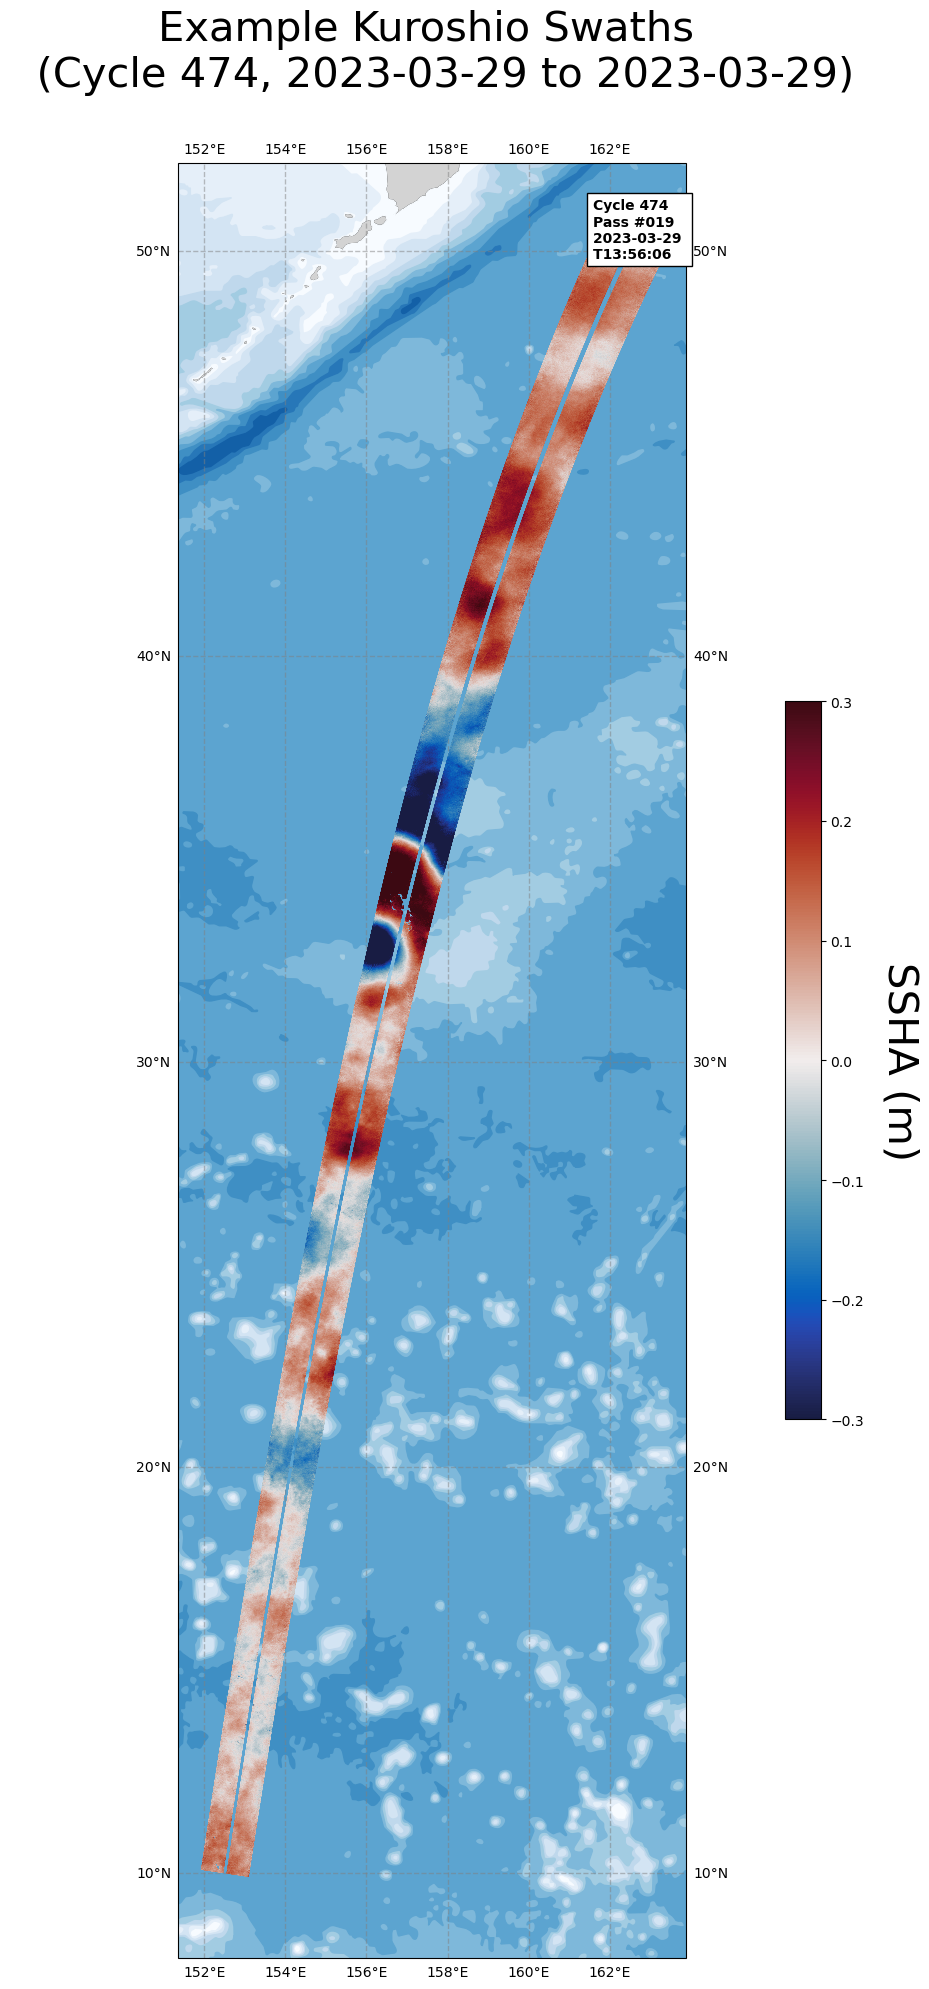

475


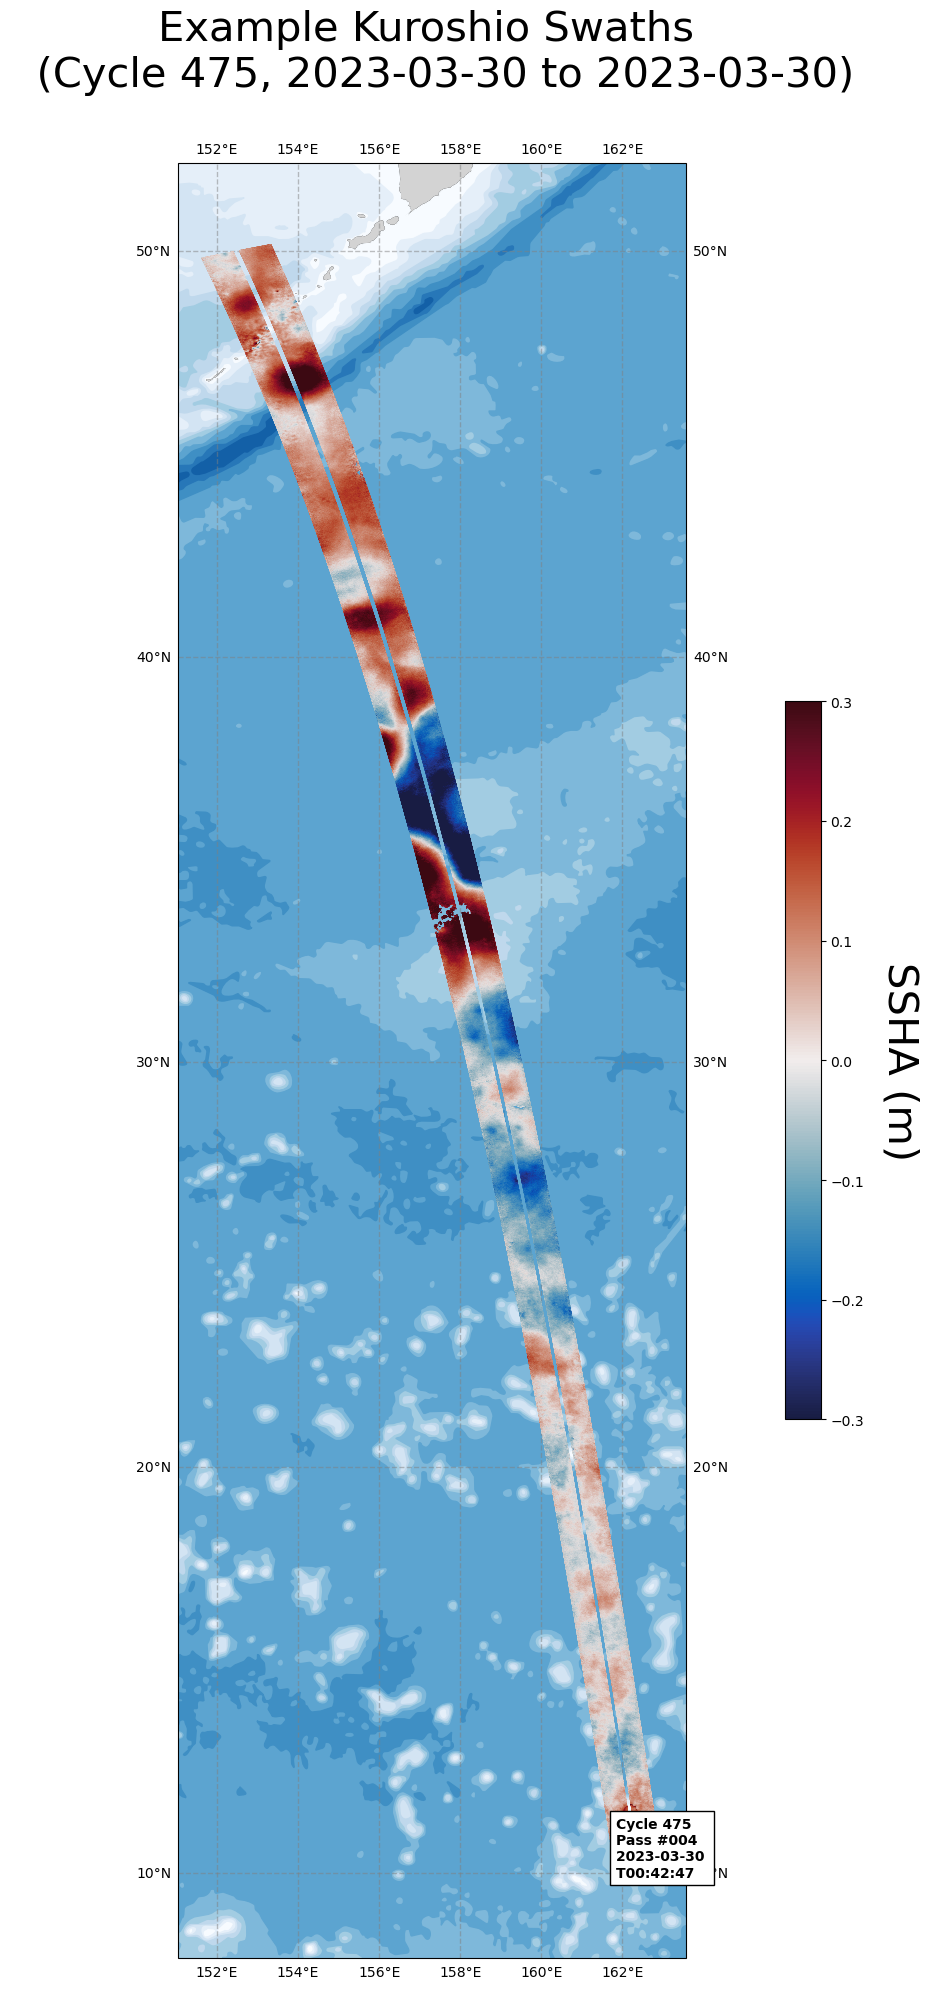

476


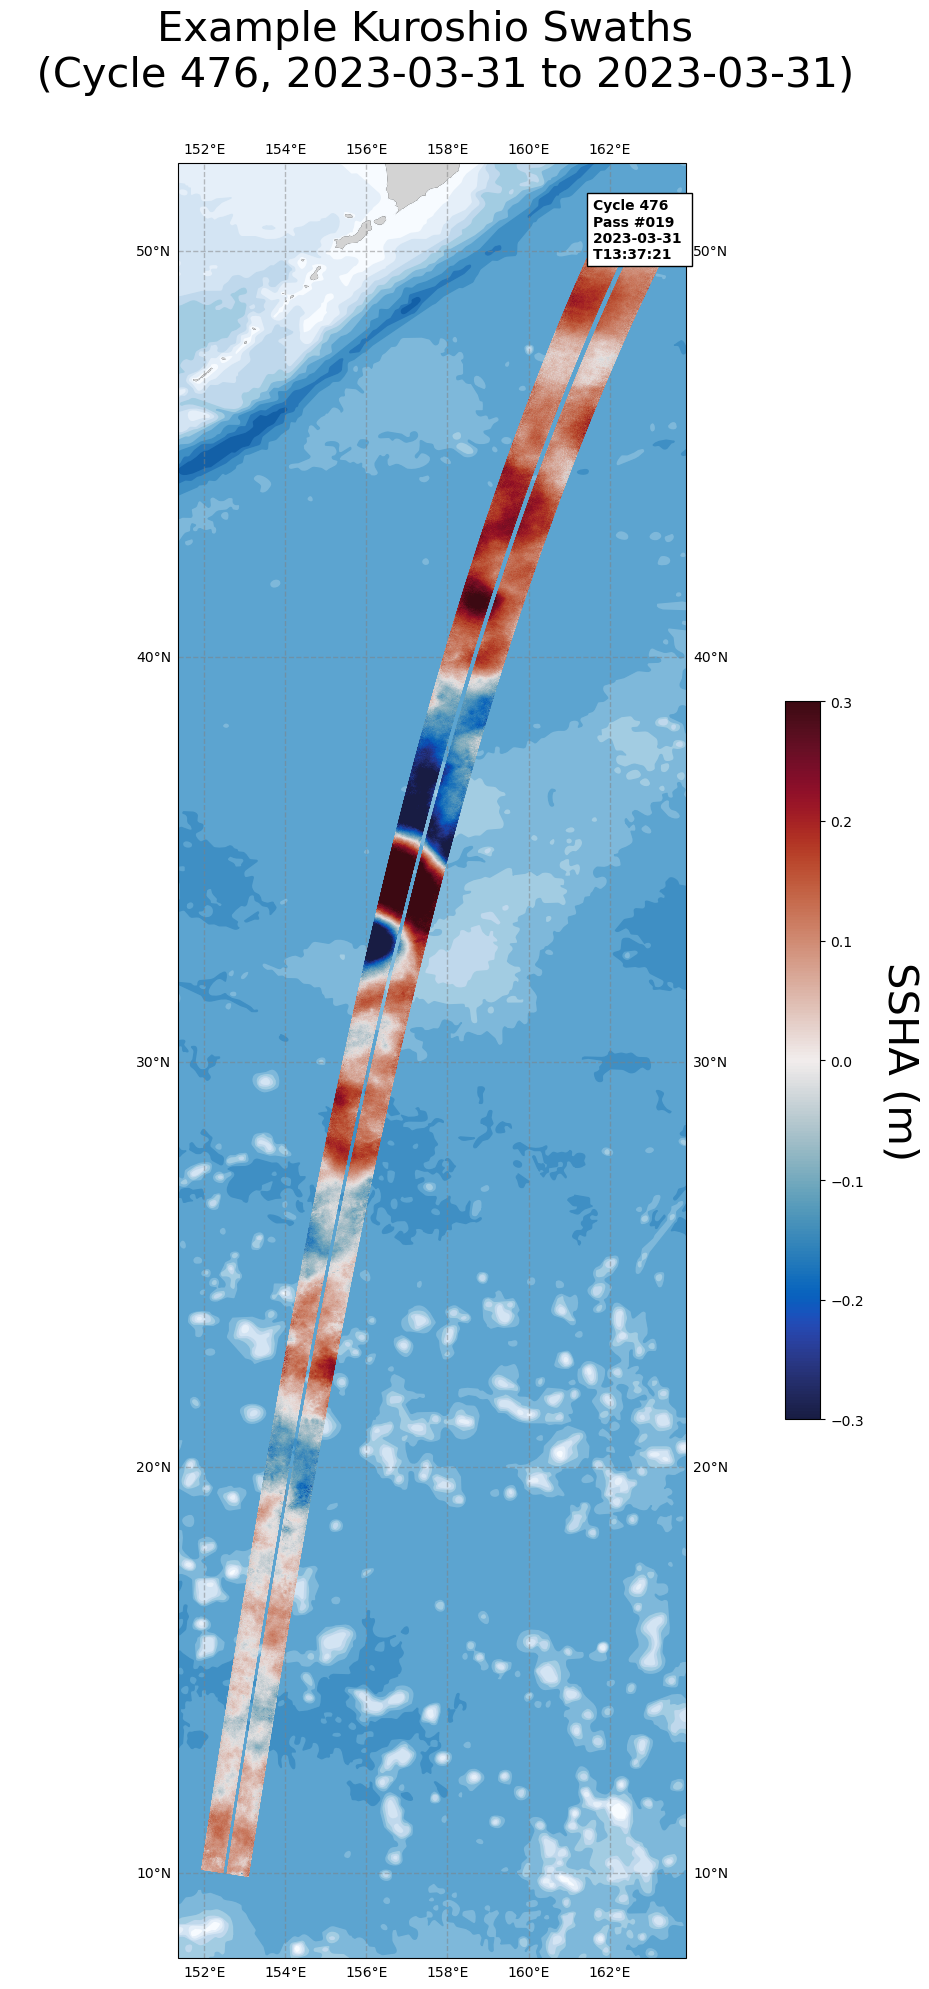

477
478
0,

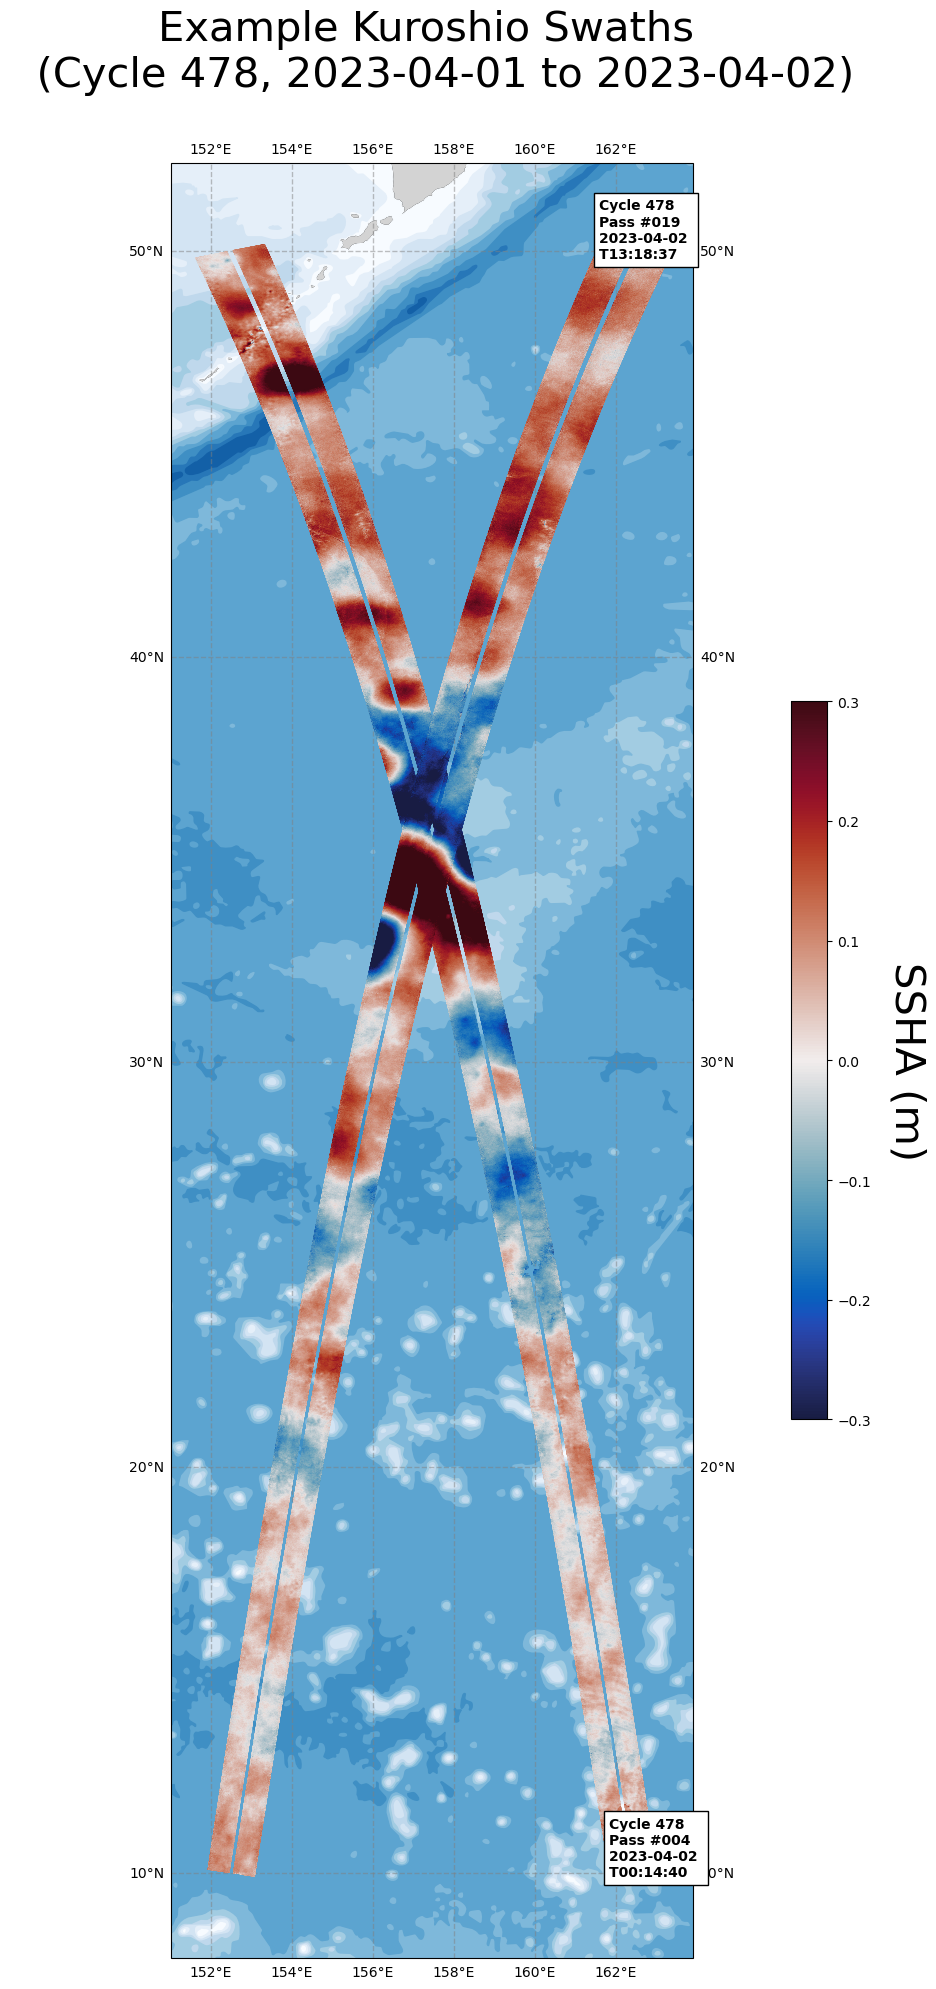

479
0,

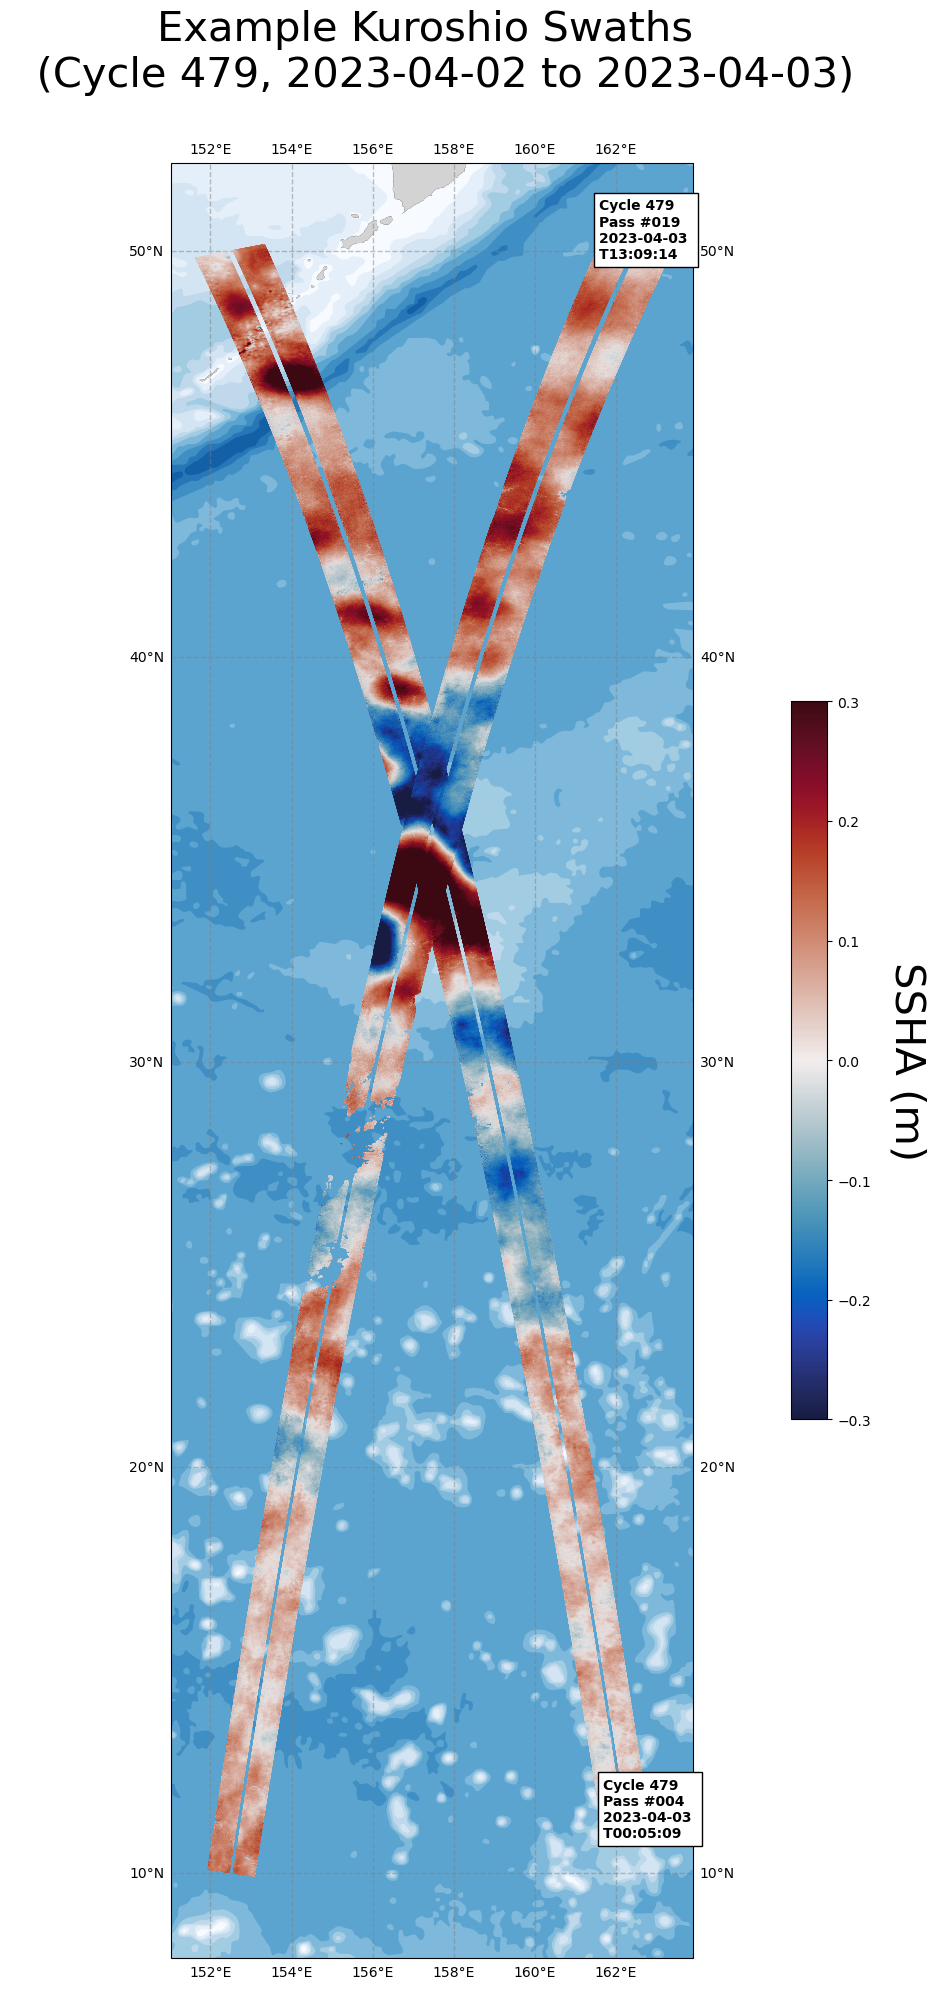

In [28]:

for cycle in cycles:
    print(cycle)
    
    if len(cycle_data[cycle])<1:
        print(f"No swaths loaded for cycle {cycle}! Skipping...")
        continue

    else:
        plot_cycle(cycle_data[cycle],title=f"Example Kuroshio Swaths \n  (Cycle {cycle}, {cycle_data[cycle][0].time_coverage_begin[:10]} to {cycle_data[cycle][-1].time_coverage_end[:10]})")

